<a href="https://colab.research.google.com/github/nsk06/Autoencoders-Compression/blob/master/Auto_Encoder_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import sys
BIN = ''
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')


In [0]:
# from nn_utils import AE_big, AE_3D_200
from my_nn_utility import AE_3D_200
from utils import plot_activations

In [308]:
torch.cuda.is_available()

True

In [0]:
fastai.torch_core.defaults.device = 'cuda'

In [340]:
# Load data
train = pd.read_pickle('all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


In [0]:
# Normalization of data as it helps in faster training and converging of gradient descent
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  #For an autoencoder the recreated output is the ground truth input
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [0]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [0]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [315]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fcef9f273c8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fcef9f19470>;

Test: None

In [358]:
model = AE_3D_200()
model

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [0]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()
#loss_func = RMSELoss()
#loss_func = my_loss_func

In [0]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-4
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [361]:
from fastai import train as tr
check = tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


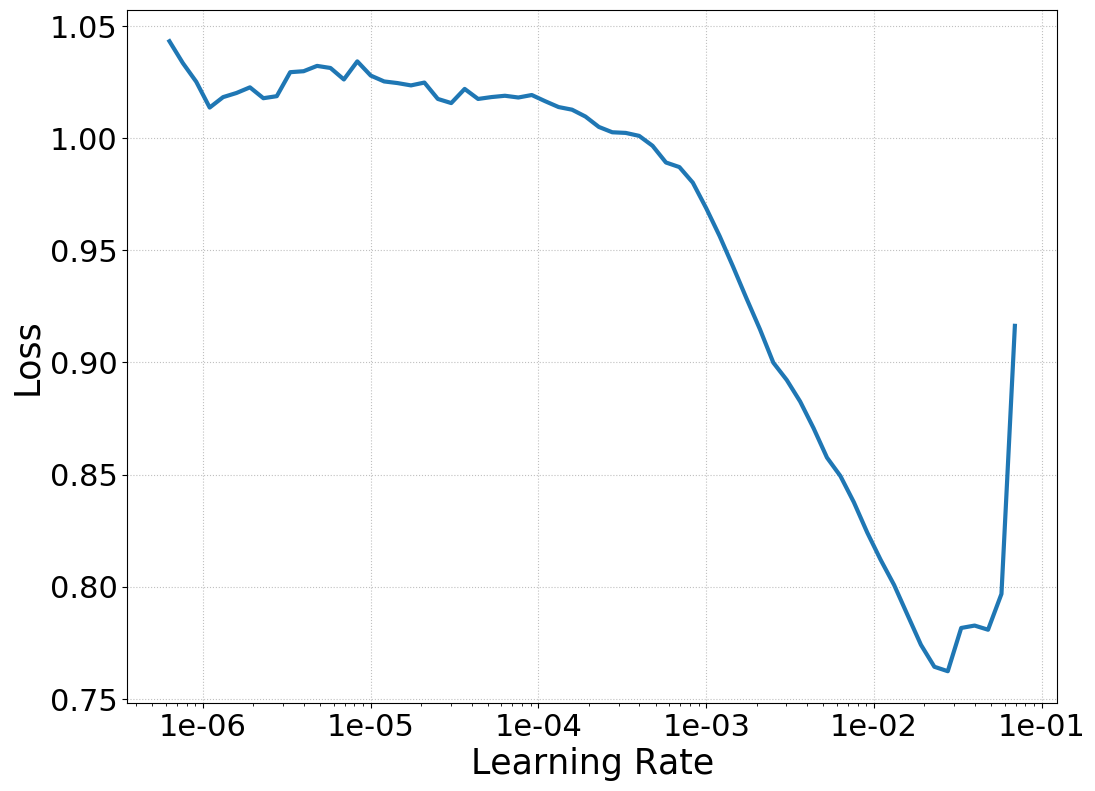

In [336]:
learn.recorder.plot()

In [362]:
lr = 1e-3
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,time
0,0.065652,0.050440,00:03
1,0.033892,0.036191,00:04
2,0.032027,0.032449,00:03
3,0.030722,0.030927,00:03
4,0.026895,0.030271,00:03
5,0.024703,0.026517,00:03
6,0.023104,0.023179,00:03
7,0.021858,0.022149,00:03
8,0.021167,0.021302,00:03
9,0.021909,0.021206,00:03


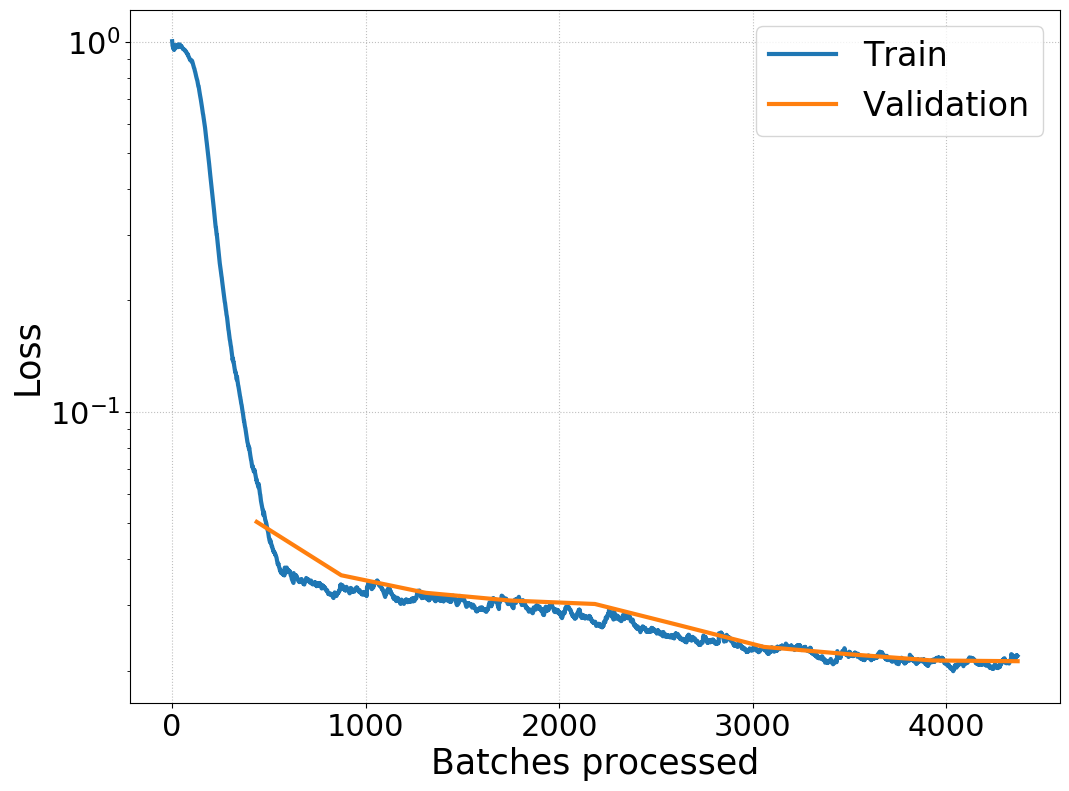

In [363]:
learn.recorder.plot_losses()
plt.yscale('log')

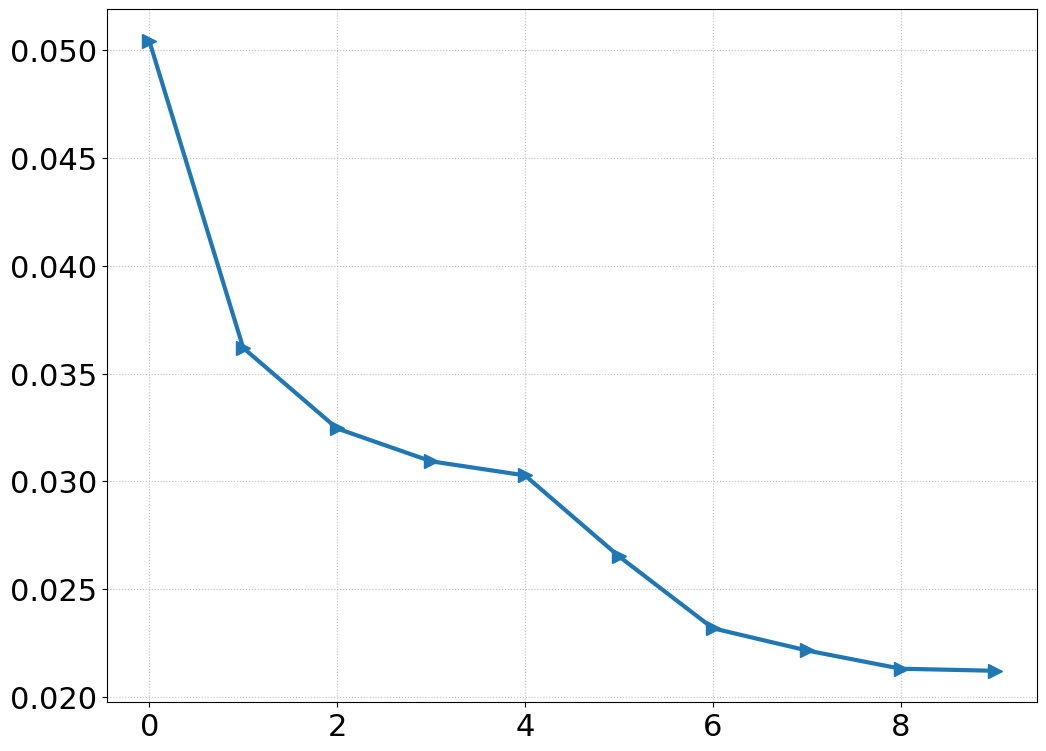

In [364]:
plt.plot(learn.recorder.val_losses, marker='>')

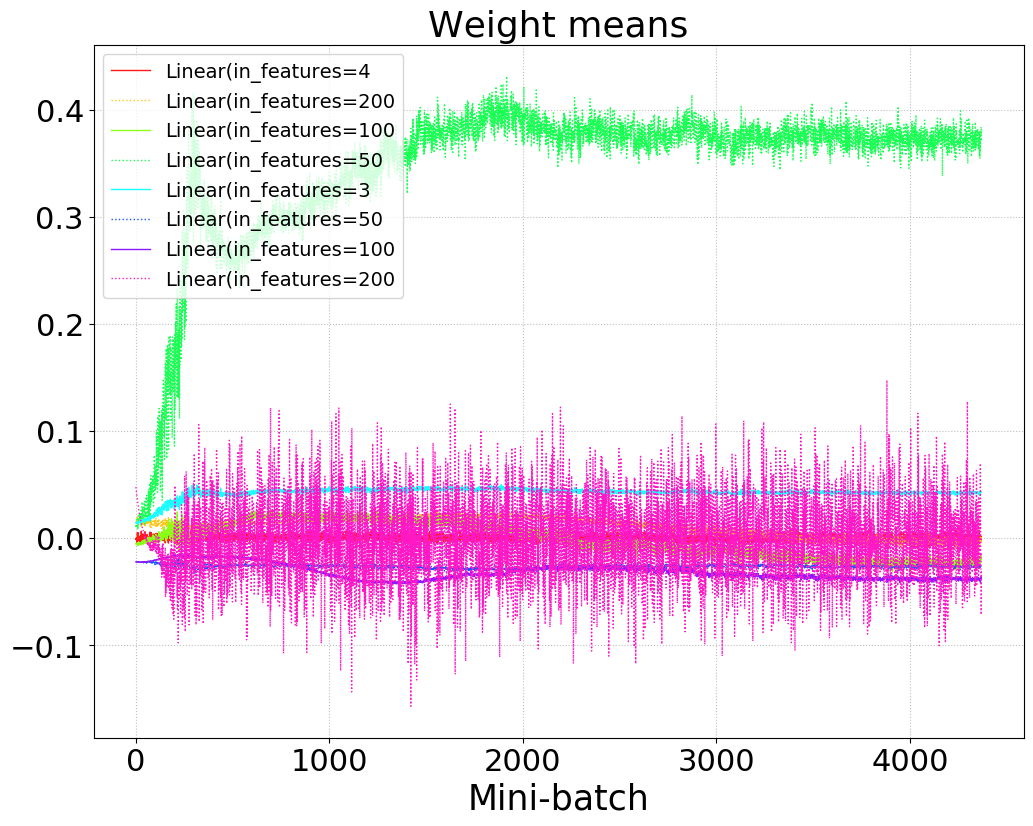

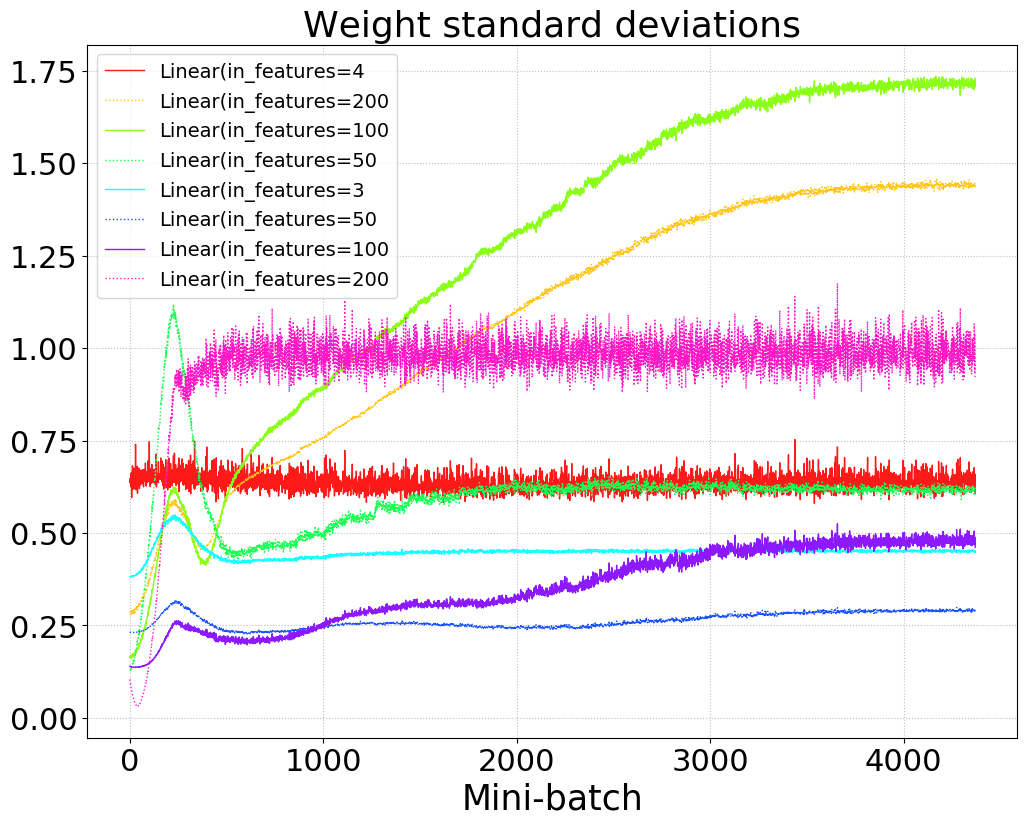

In [365]:
plot_activations(learn)

In [231]:
learn.validate()

[0.01618778]

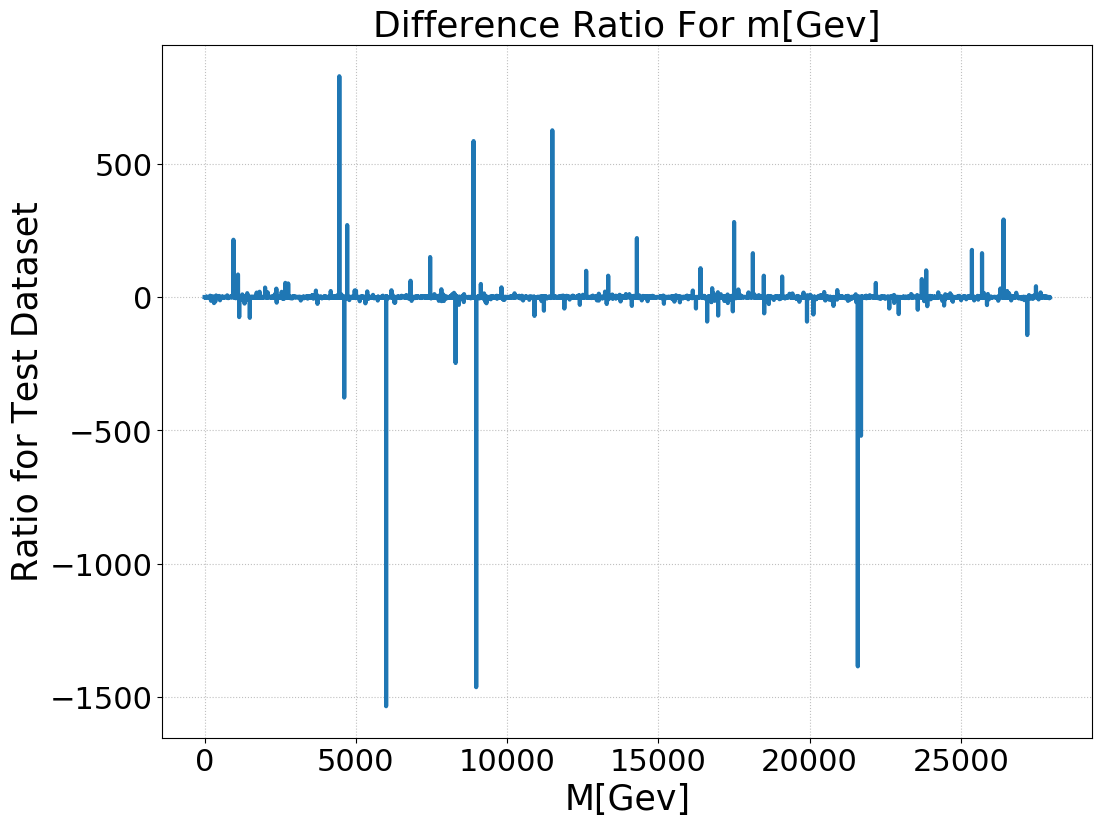

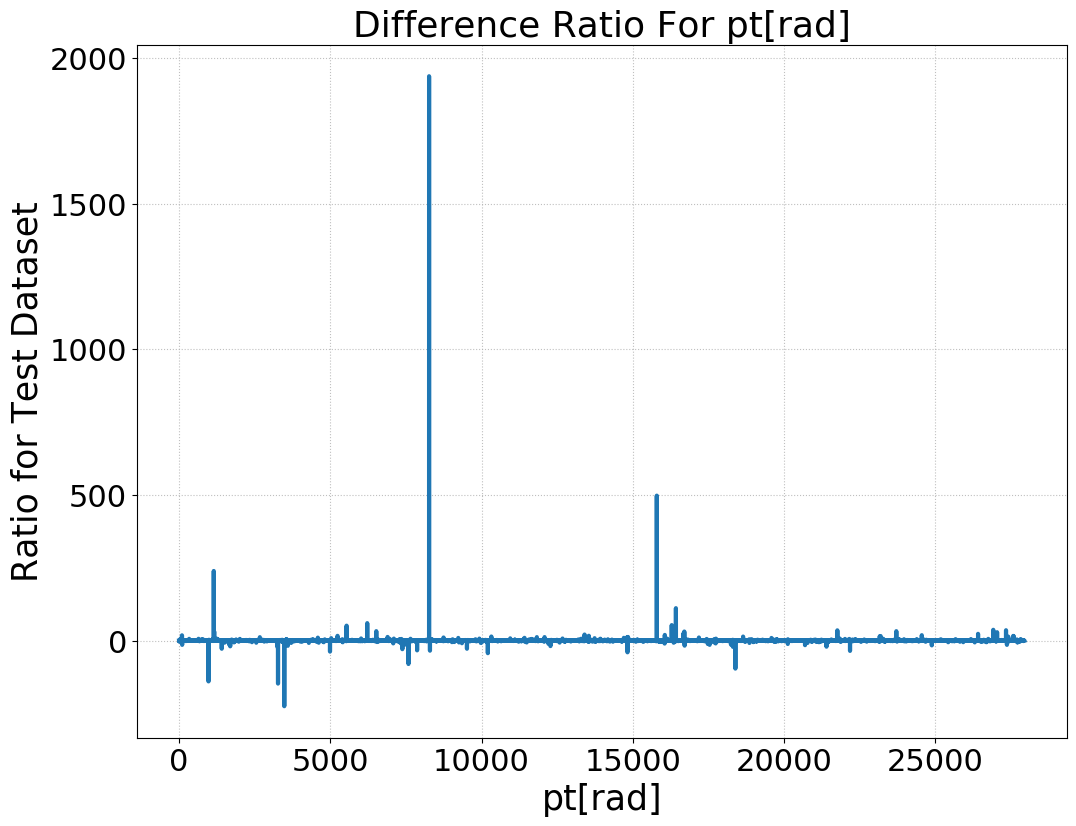

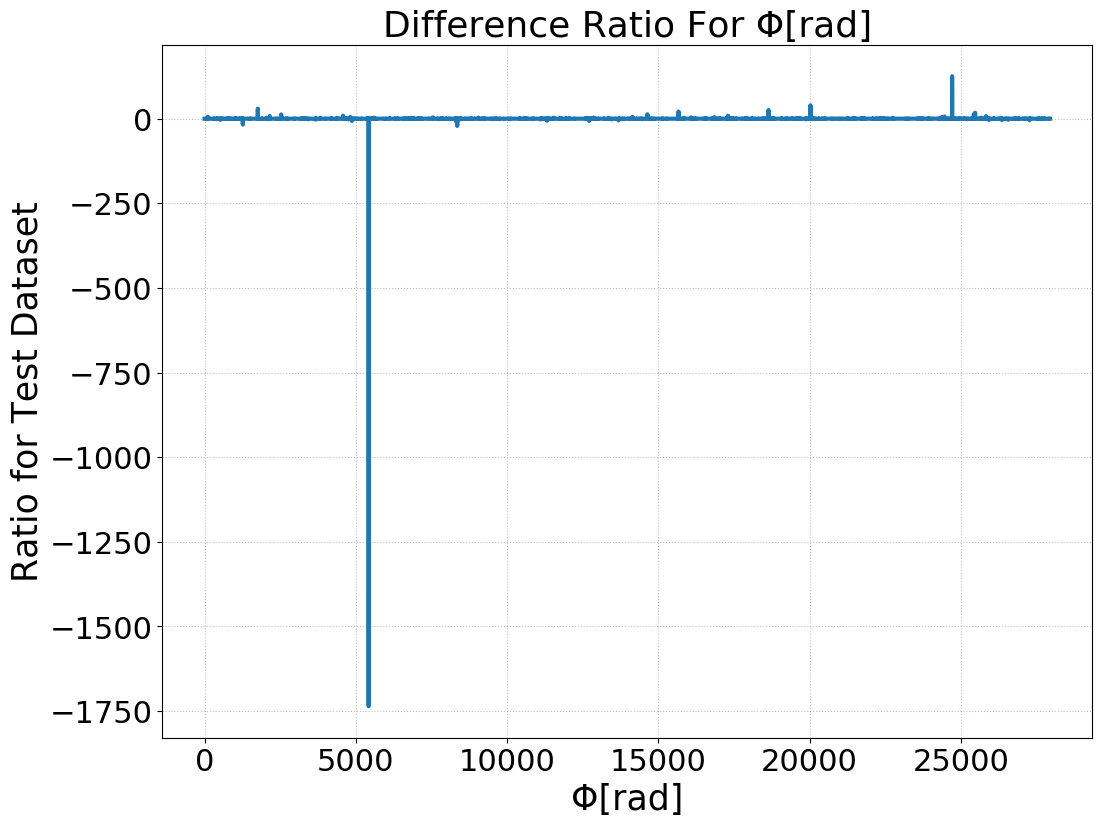

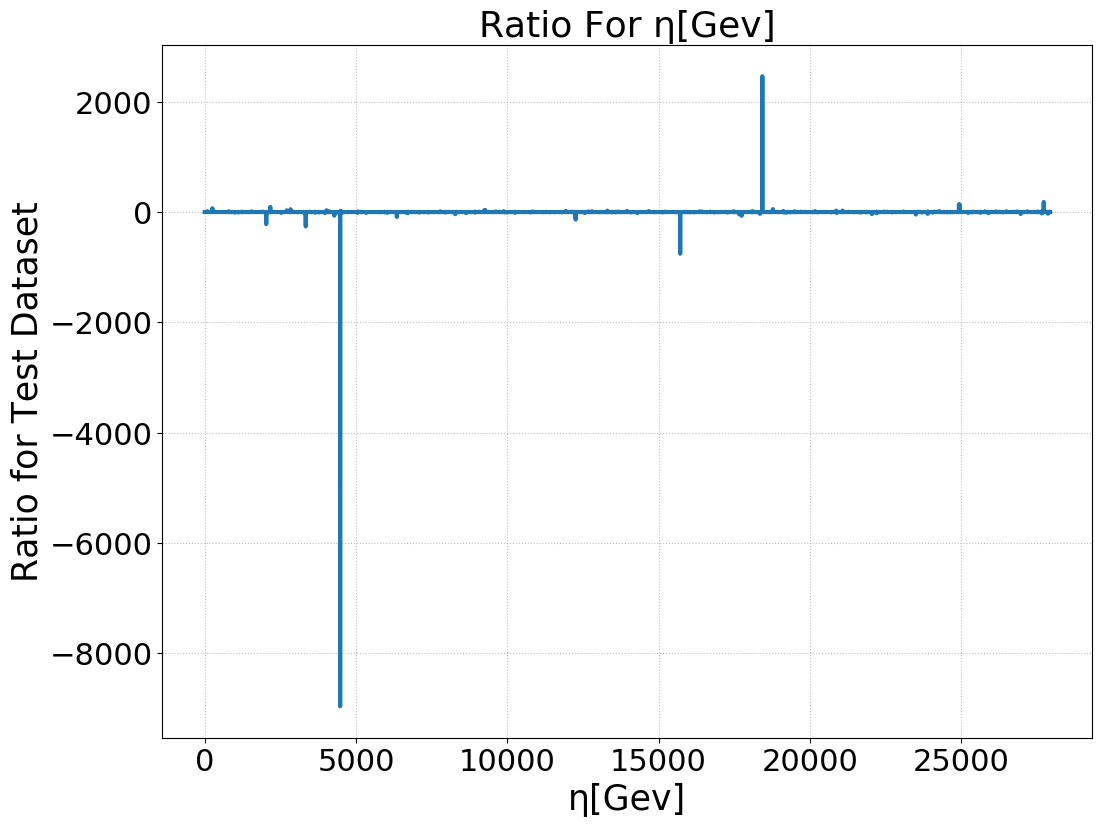

In [368]:
# for x in learn.data.valid_dl:
#   learn.predict(x)
out = learn.get_preds()[0].numpy()
inp = test_x.to_numpy()
ratio_pl=(inp-out)/inp
plt.plot(np.arange(len(ratio_pl[:,0])),ratio_pl[:,0])
plt.title("Difference Ratio For m[Gev]")
plt.ylabel('Ratio for Test Dataset')
plt.xlabel('M[Gev]')
plt.show()
plt.plot(np.arange(len(ratio_pl[:,1])),ratio_pl[:,1])
plt.title("Difference Ratio For pt[rad]")
plt.ylabel('Ratio for Test Dataset')
plt.xlabel('pt[rad]')
plt.show()
plt.plot(np.arange(len(ratio_pl[:,2])),ratio_pl[:,2])
plt.title("Difference Ratio For Φ[rad]")
plt.ylabel('Ratio for Test Dataset')
plt.xlabel('Φ[rad]')
plt.show()
plt.plot(np.arange(len(ratio_pl[:,3])),ratio_pl[:,3])
plt.title("Ratio For η[Gev]")
plt.ylabel('Ratio for Test Dataset')
plt.xlabel('η[Gev]')
plt.show()

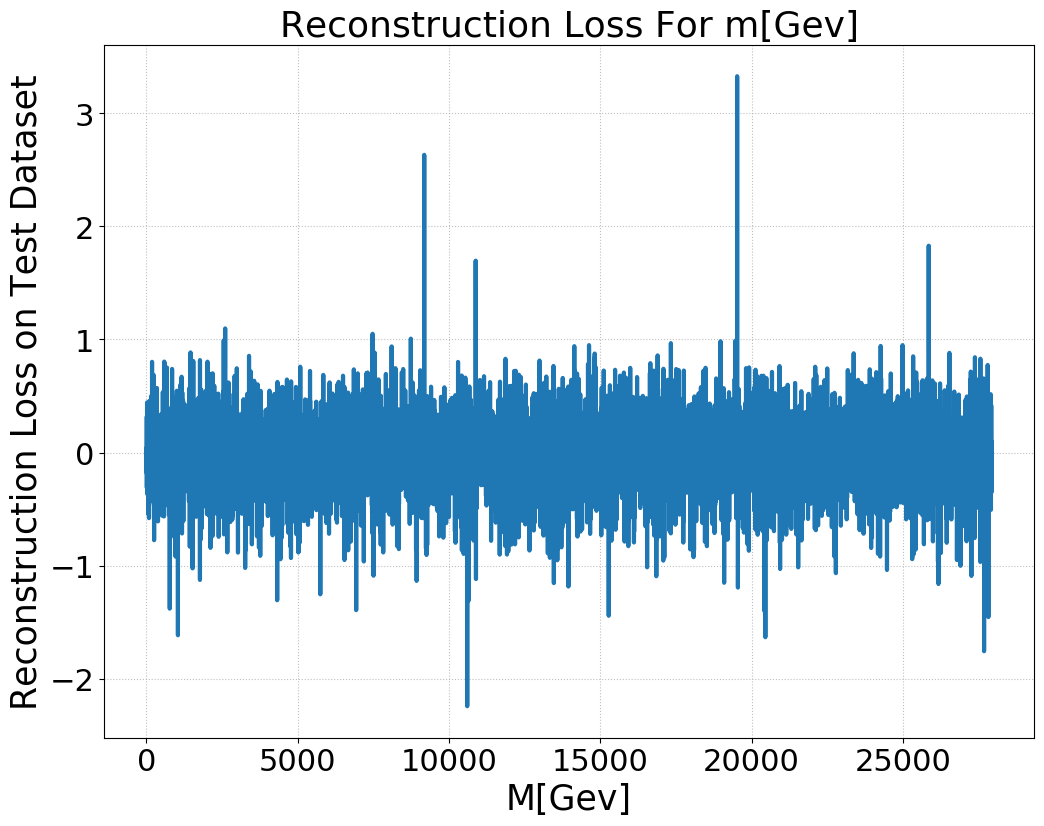

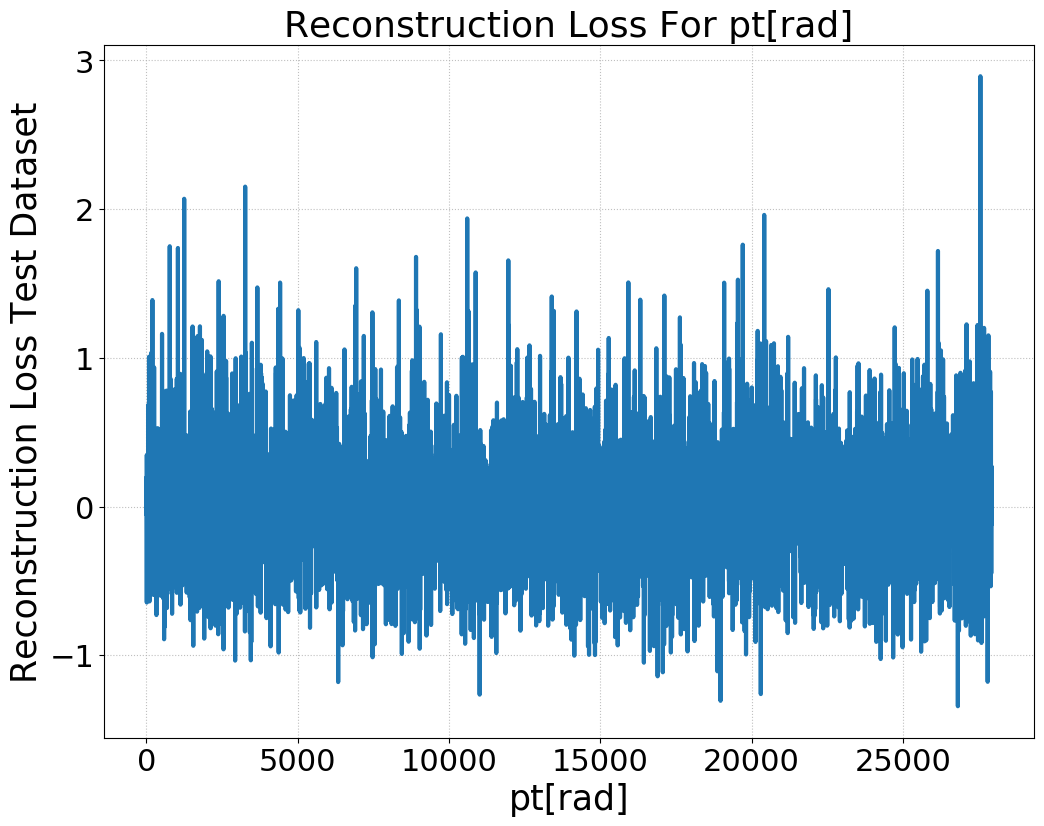

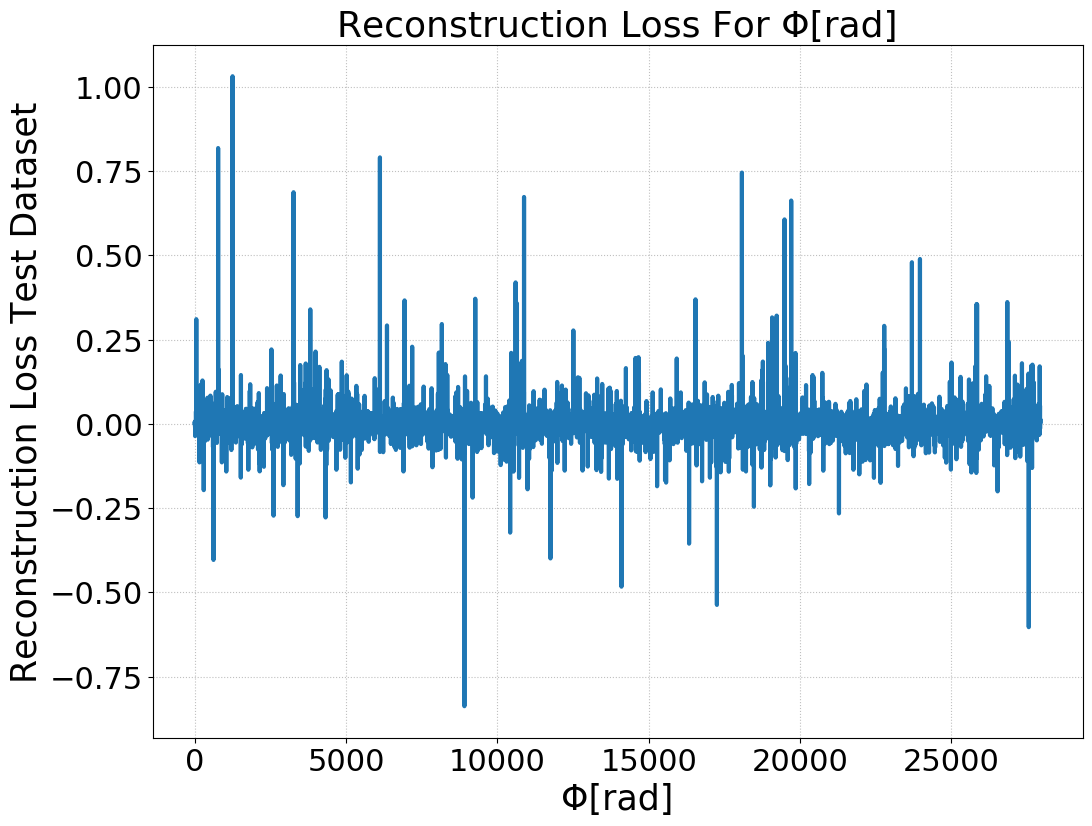

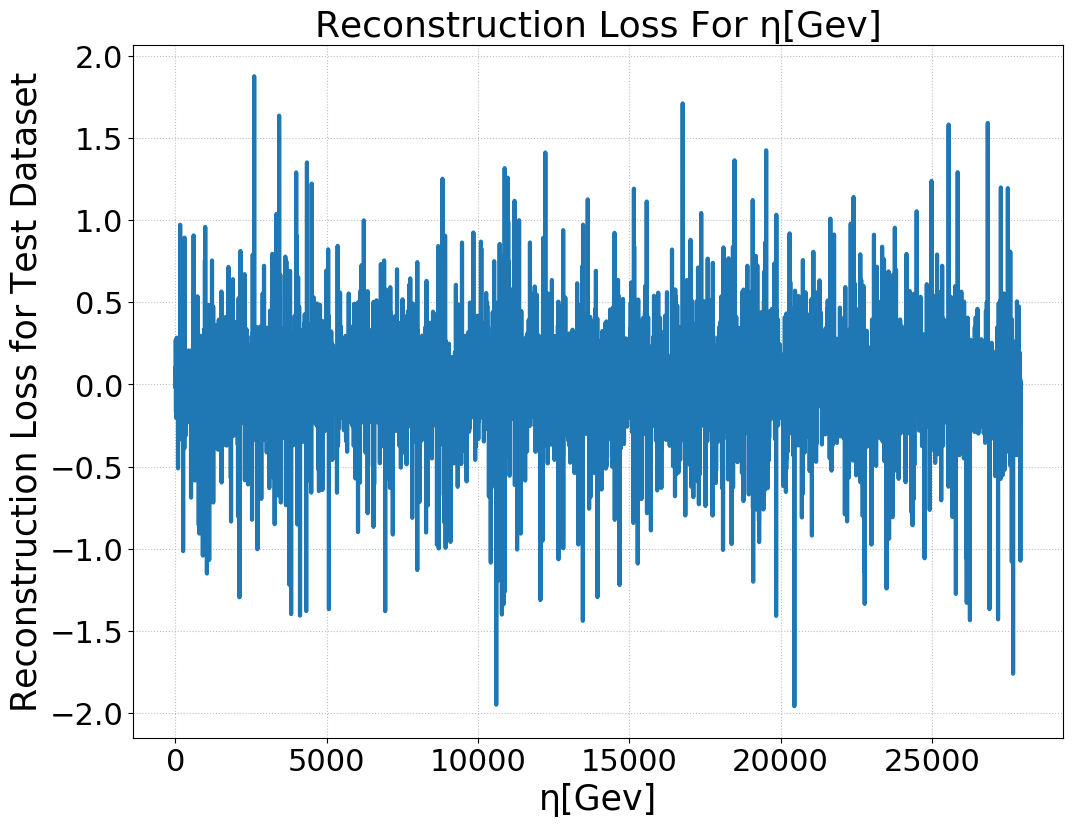

In [369]:
out = learn.get_preds()[0].numpy()
inp = test_x.to_numpy()
reconstruction=(inp-out)
plt.plot(np.arange(len(reconstruction[:,0])),reconstruction[:,0])
plt.title("Reconstruction Loss For m[Gev]")
plt.ylabel('Reconstruction Loss on Test Dataset')
plt.xlabel('M[Gev]')
plt.show()
plt.plot(np.arange(len(reconstruction[:,1])),reconstruction[:,1])
plt.title("Reconstruction Loss For pt[rad]")
plt.ylabel('Reconstruction Loss Test Dataset')
plt.xlabel('pt[rad]')
plt.show()
plt.plot(np.arange(len(reconstruction[:,2])),reconstruction[:,2])
plt.title("Reconstruction Loss For Φ[rad]")
plt.ylabel('Reconstruction Loss Test Dataset')
plt.xlabel('Φ[rad]')
plt.show()
plt.plot(np.arange(len(reconstruction[:,3])),reconstruction[:,3])
plt.title("Reconstruction Loss For η[Gev]")
plt.ylabel('Reconstruction Loss for Test Dataset')
plt.xlabel('η[Gev]')
plt.show()